In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Prometheus API URL and query
PROMETHEUS_API_URL = "http://10.105.116.175:9090/api/v1/query_range"
PROMETHEUS_QUERY_throughput = ["rate(istio_requests_total{namespace='social-network2'}[1m])",                             
                               "rate(istio_requests_total{namespace='social-network4'}[1m])"]
PROMETHEUS_QUERY_latency_avg = [ "rate(istio_request_duration_milliseconds_sum{namespace='social-network2', response_code = '200'}[1m])/ rate(istio_requests_total{namespace='social-network2',response_code = '200'}[1m])",
                                 "rate(istio_request_duration_milliseconds_sum{namespace='social-network4',response_code = '200'}[1m])/ rate(istio_requests_total{namespace='social-network4',response_code = '200'}[1m])"]

# PROMETHEUS_QUERY_latency_p95 = "histogram_quantile(0.95, sum(rate(istio_request_duration_milliseconds_bucket{namespace='social-network'}[1m])) by (le))"
# Function to query Prometheus API
def query_prometheus(prometheus_url, query, start, end, step):
    params = {
        'query': query,
        'start': start.timestamp(),
        'end': end.timestamp(),
        'step': step
    }
    response = requests.get(prometheus_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse Prometheus response
def parse_prometheus_data(data, check_start_time=None, check_end_time=None):
    results = data['data']['result']
    data_list = []
    for result in results:
        metric = result['metric']
        if 'values' in result:
            for value in result['values']:
                timestamp = datetime.utcfromtimestamp(value[0])
                metric_value = float(value[1])

                if (check_start_time is None or timestamp >= check_start_time) and \
                   (check_end_time is None or timestamp <= check_end_time):
                    data_list.append({
                        "metric": metric,
                        "timestamp": timestamp,
                        "value": metric_value
                    })
        else:
            print(f"No 'values' key found in result: {result}")
    return pd.DataFrame(data_list)




In [2]:


move_back_minutes = 0 # Adjust based on actual query
# check_start_time = datetime.now() - timedelta(minutes=move_back_minutes + 60)  # 20 minutes ago
check_start_time = datetime(2025, 3, 19, 8, 49, 0) # UTC time
check_end_time = datetime(2025, 3, 19, 9, 29, 0)
step = "10s"  # Resolution


# Get current date and time
now = datetime.now()
timestamp = now.strftime("%Y_%b_%d_%H%M")  # Example: 2024_Oct_20_1930

# write a loop to get the data for each query
strategies = ['policy1','policy4']
for i in range(0,2):
    # Fetch data from Prometheus
    data_latency_avg = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[i], check_start_time, check_end_time, step)
    df_latency_avg = parse_prometheus_data(data_latency_avg, check_start_time, check_end_time)
    df_latency_avg.to_csv(f'data/{strategies[i]}_{timestamp}_latency.csv', mode='a', header=False, index=False)
    print(f" {strategies[i]} Latency Data has been saved to CSV file")
    
    
    

 policy1 Latency Data has been saved to CSV file
 policy4 Latency Data has been saved to CSV file


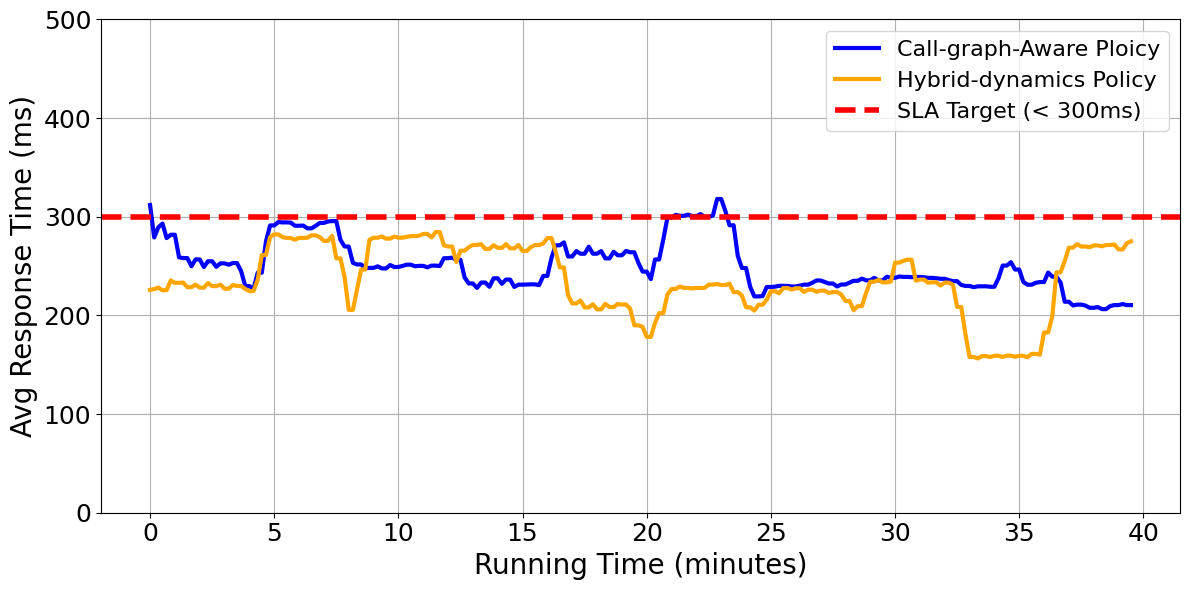

In [9]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Assume strategies and timestamp are defined elsewhere, for example:
# strategies = ['strategy1', 'strategy2']
# timestamp = '20250204'
colors = ['blue', 'orange', 'green']  # Colors for each strategy
labels = ['Call-graph-Aware Ploicy', 'Hybrid-dynamics Policy']  # Labels for each strategy

# Create a single figure before the loop
plt.figure(figsize=(12, 6))

for j in range(0, 2):
    # Construct the file path and load the CSV file
    file_path = f'data/{strategies[j]}_{timestamp}_latency.csv'
    df = pd.read_csv(file_path)
    
    # Convert the first column to dictionaries
    df.iloc[:, 0] = df.iloc[:, 0].apply(ast.literal_eval)
    
    # Extract the 'app' key from each dictionary to create a 'metric' column
    df['metric'] = df.iloc[:, 0].apply(lambda x: x.get('app'))
    
    # Convert the second column (assumed to be a timestamp) to datetime
    df['timestamp'] = pd.to_datetime(df[df.columns[1]])
    
    # Calculate elapsed time in seconds from the start of data collection
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
    
    if not df.empty:
        # Group the data by the 'metric' column and plot each group
        for key, grp in df.groupby('metric'):
            # To avoid duplicate legend entries when there are multiple groups,
            # you might want to include the metric in the label. If each CSV contains
            # only one metric, you could also simply label with strategies[j].
            plt.plot(grp['elapsed_time']/60, grp[df.columns[2]],
                    #  label=f"{strategies[j]} - {key}",
                    label=labels[j],
                     color=colors[j],linewidth=3)

# Add the QoS target horizontal line (red dashed line at y=300)
plt.axhline(y=300, color='red', linestyle='--', label='SLA Target (< 300ms)', linewidth=4)


# Customize axis fonts and limits
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 500)
plt.xlabel('Running Time (minutes)', fontsize=20)
plt.ylabel('Avg Response Time (ms)', fontsize=20)
plt.grid(True)

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()

# Finally, display the combined plot
plt.show()


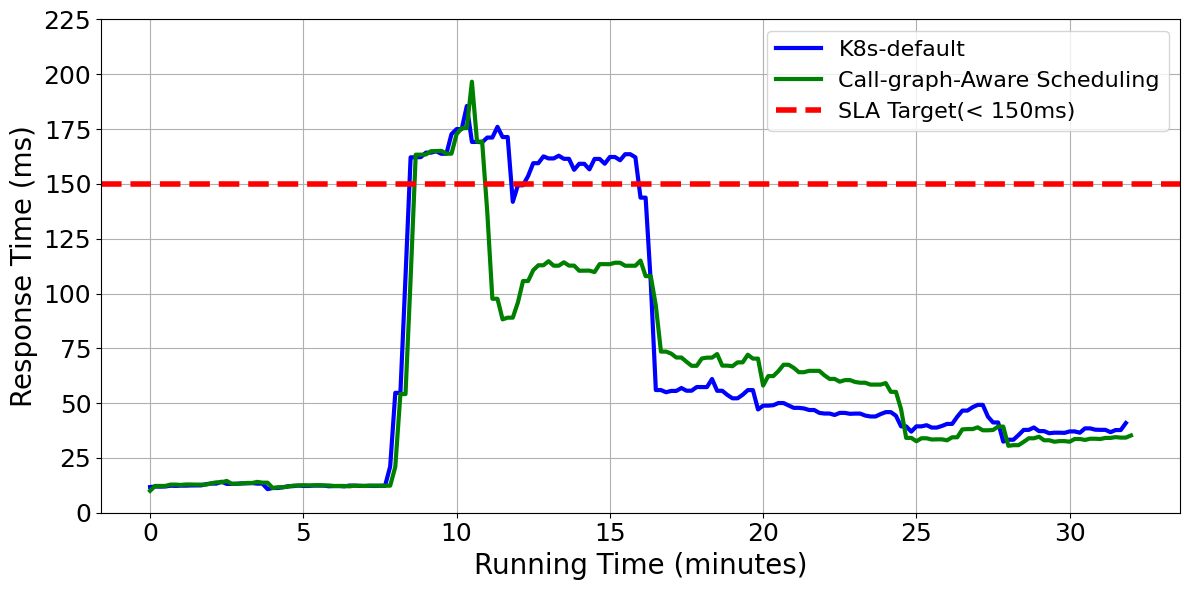

In [47]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import ast
import os

PROMETHEUS_API_URL = "http://10.105.116.175:9090/api/v1/query_range"
PROMETHEUS_QUERY_latency_avg = "rate(istio_request_duration_milliseconds_sum{namespace='social-network', response_code='200'}[1m])/ rate(istio_requests_total{namespace='social-network',response_code='200'}[1m])"

QoS_target = 150
colors = ['blue', 'green']

# Function to query Prometheus API
def query_prometheus(prometheus_url, query, start, end, step):
    params = {'query': query, 'start': start.timestamp(), 'end': end.timestamp(), 'step': step}
    response = requests.get(prometheus_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse Prometheus response
def parse_prometheus_data(data, check_start_time, check_end_time):
    results = data['data']['result']
    data_list = []
    for result in results:
        metric = result['metric']
        for value in result.get('values', []):
            timestamp = datetime.utcfromtimestamp(value[0])
            metric_value = float(value[1])
            if check_start_time <= timestamp <= check_end_time:
                data_list.append({"metric": metric, "timestamp": timestamp, "value": metric_value})
    return pd.DataFrame(data_list)

# Query time ranges
k8s_start_time = datetime(2025, 3, 18, 6, 54, 0)
k8s_end_time = datetime(2025, 3, 18, 7, 26, 0)
callGraph_start_time = datetime(2025, 3, 18, 7, 29, 0)
callGraph_end_time = datetime(2025, 3, 18, 8, 1, 0)
step = "10s"

# Fetch data from Prometheus
data_k8s = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg, k8s_start_time, k8s_end_time, step)
data_callGraph = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg, callGraph_start_time, callGraph_end_time, step)

# Parse dataframes
df_k8s = parse_prometheus_data(data_k8s, k8s_start_time, k8s_end_time)
df_callGraph = parse_prometheus_data(data_callGraph, callGraph_start_time, callGraph_end_time)

# Save dataframes
os.makedirs('data', exist_ok=True)
timestamp = datetime.now().strftime("%Y_%b_%d_%H%M")
df_k8s.to_csv(f'data/k8s_{timestamp}_avg_latency.csv', index=False)
df_callGraph.to_csv(f'data/callGraph_{timestamp}_avg_latency.csv', index=False)

# Load dataframes back from files
df_k8s_loaded = pd.read_csv(f'data/k8s_{timestamp}_avg_latency.csv', parse_dates=['timestamp'])
df_callGraph_loaded = pd.read_csv(f'data/callGraph_{timestamp}_avg_latency.csv', parse_dates=['timestamp'])

# Align plots to start from zero elapsed time
for df in [df_k8s_loaded, df_callGraph_loaded]:
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plotting
plt.figure(figsize=(12, 6))

for df, label, color in zip([df_k8s_loaded, df_callGraph_loaded], ['K8s-default', 'Call-graph-Aware Scheduling'], colors):
    df_sorted = df.sort_values(by='elapsed_time')
    plt.plot(df_sorted['elapsed_time']/60, df_sorted['value'], label=label, color=color, linewidth=3)

# QoS Target line
plt.axhline(y=QoS_target, color='red', linestyle='--', linewidth =4, label=f'SLA Target(< {QoS_target}ms)')

# Customize plot
plt.ylim(0, QoS_target * 1.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Running Time (minutes)', fontsize=20)
plt.ylabel('Response Time (ms)', fontsize=20)
plt.grid(True)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()

# Display plot
plt.show()


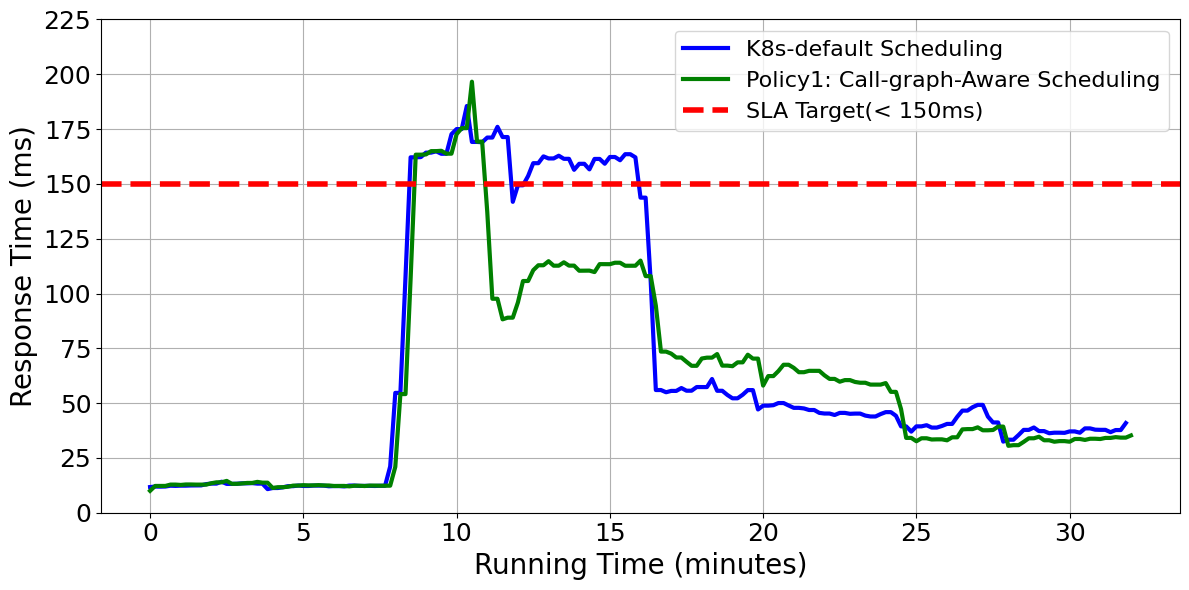

In [8]:

import pandas as pd

import matplotlib.pyplot as plt

QoS_target = 150
colors = ['blue', 'green']
# Load dataframes back from files
callGraph_file_path = "/home/ubuntu/iDynamics/iDynamicsPackagesModules/Evaluations/Policy1_eval_Graph_dynamics/Policy1_evaluated_data/data/callGraph_2025_Mar_18_1156_avg_latency.csv"
k8s_file_path ='/home/ubuntu/iDynamics/iDynamicsPackagesModules/Evaluations/Policy1_eval_Graph_dynamics/Policy1_evaluated_data/data/k8s_2025_Mar_18_1156_avg_latency.csv'
df_k8s_loaded = pd.read_csv(k8s_file_path, parse_dates=['timestamp'])
df_callGraph_loaded = pd.read_csv(callGraph_file_path, parse_dates=['timestamp'])

# Align plots to start from zero elapsed time
for df in [df_k8s_loaded, df_callGraph_loaded]:
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plotting
plt.figure(figsize=(12, 6))

for df, label, color in zip([df_k8s_loaded, df_callGraph_loaded], ['K8s-default Scheduling', 'Policy1: Call-graph-Aware Scheduling'], colors):
    df_sorted = df.sort_values(by='elapsed_time')
    plt.plot(df_sorted['elapsed_time']/60, df_sorted['value'], label=label, color=color, linewidth=3)

# QoS Target line
plt.axhline(y=QoS_target, color='red', linestyle='--', linewidth =4, label=f'SLA Target(< {QoS_target}ms)')

# Customize plot
plt.ylim(0, QoS_target * 1.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Running Time (minutes)', fontsize=20)
plt.ylabel('Response Time (ms)', fontsize=20)
plt.grid(True)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()

# Display plot
plt.show()
